<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/TimeSeries_Seq_2_Seq/Seq2Seq_Basique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

Matplotlib is building the font cache; this may take a moment.


In [ ]:
import keras
import tensorflow as tf


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5055800945560848044
]


# Chargement et correction des données

**1. Chargement des données**

In [2]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Seq2Seq/Data/Power_PV.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   177  100   177    0     0    292      0 --:--:-- --:--:-- --:--:--   292
100 1790k  100 1790k    0     0  2027k      0 --:--:-- --:--:-- --:--:-- 2027k


**2. Analyse et correction des données**

In [3]:
# Création de la série sous Pandas
df_data = pd.read_csv("Power_PV.csv")
df_data

,Date,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
0,2018-07-01 00:00:00,18.230667,78.229330,1.434800,930.0,0.0,0.0
1,2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2,2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
3,2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
4,2018-07-01 01:00:00,18.384000,77.567340,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...,...
27548,2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
27549,2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
27550,2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0
27551,2019-04-13 23:45:00,21.374666,86.200000,1.666067,929.0,0.0,0.0


Affiche les types :

In [4]:
df_data.dtypes

Date                       object
Temp. (°C)                float64
Humid. Rel (%)            float64
Vent (m/s)                float64
Pression (mbar)           float64
Ensolleillement (W/m2)    float64
watts                     float64
dtype: object

Converison des types `object` en `float32` :

In [5]:
df_data.iloc[:,1:] = pd.DataFrame.replace(df_data.iloc[:,1:],"?","NaN")
df_data.iloc[:,1:] = df_data.iloc[:,1:].astype(np.float32)
df_data

,Date,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
0,2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0,0.0
1,2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2,2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
3,2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
4,2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...,...
27548,2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
27549,2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
27550,2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0
27551,2019-04-13 23:45:00,21.374666,86.199997,1.666067,929.0,0.0,0.0


In [6]:
df_data.dtypes

Date                       object
Temp. (°C)                float32
Humid. Rel (%)            float32
Vent (m/s)                float32
Pression (mbar)           float32
Ensolleillement (W/m2)    float32
watts                     float32
dtype: object

In [7]:
# Définition des dates de début et de fin

#date_debut = "2018-07-01 00:00:00"
date_debut = "2018-10-01 00:00:00"
date_fin = "2019-04-14 00:00:00"

# Place l'index du dataframe sur la colonne Date
df_data = df_data.rename(columns={'Unnamed: 0': "Date"})
df_data = df_data.set_index(df_data['Date'])

# Copie des données dans le dataframe d'étude sur l'intervalle d'étude
df_etude = df_data.loc[date_debut:date_fin].copy()

# Conversion de la colonne Date au format datetime
df_etude.index = pd.to_datetime(df_etude.index)

# Suppression de la colonne Unnamed:0
df_etude = df_etude.drop("Date", axis=1)
df_etude

,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
Date,,,,,,
2018-10-01 00:00:00,22.144667,66.740669,2.801867,928.000000,0.0,0.0
2018-10-01 00:15:00,21.946667,68.166664,3.258133,928.000000,0.0,0.0
2018-10-01 00:30:00,21.760666,69.404663,3.170333,928.000000,0.0,0.0
2018-10-01 00:45:00,21.572666,70.346001,3.205600,928.000000,0.0,0.0
2018-10-01 01:00:00,21.393999,71.177330,3.062667,927.733337,0.0,0.0
...,...,...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.000000,0.0,0.0
2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.000000,0.0,0.0
2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.000000,0.0,0.0


Vérification des données et correction des anomalies :

In [8]:
data_manquantes = sum(np.isnan(df_etude['watts']))
print ("Données manquantes : %s" %data_manquantes)

Données manquantes : 62


In [9]:
df_etude = df_etude.fillna(method="backfill")

In [10]:
data_manquantes = sum(np.isnan(df_etude['watts']))
print ("Données manquantes : %s" %data_manquantes)

Données manquantes : 0


**5. Affiche les données**

In [11]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_etude.index,y=df_etude['watts'], line=dict(color='blue', width=1),name="Puissance (W)"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Analyse de la série

**1. ACF & PACF**

In [ ]:
# ACF & PACF du bruit blanc

serie = df_etude['watts'].values

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie, ax=ax1, lags = range(0,500))
ax1.set_title("Autocorrélation")

plot_pacf(serie, ax=ax2, lags = range(0, 500))
ax2.set_title("Autocorrélation partielle")

# Séparation des données de test et d'entrainement

In [12]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude['watts'].values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude['watts'].values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude['watts'].values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 14976
Taille de la validation : 3745


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [13]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
serie_entrainement_X_norm = min_max_scaler.fit_transform(tf.reshape(serie_entrainement_X,shape=(len(serie_entrainement_X),1)))
serie_test_X_norm = min_max_scaler.fit_transform(tf.reshape(serie_test_X,shape=(len(serie_test_X),1)))

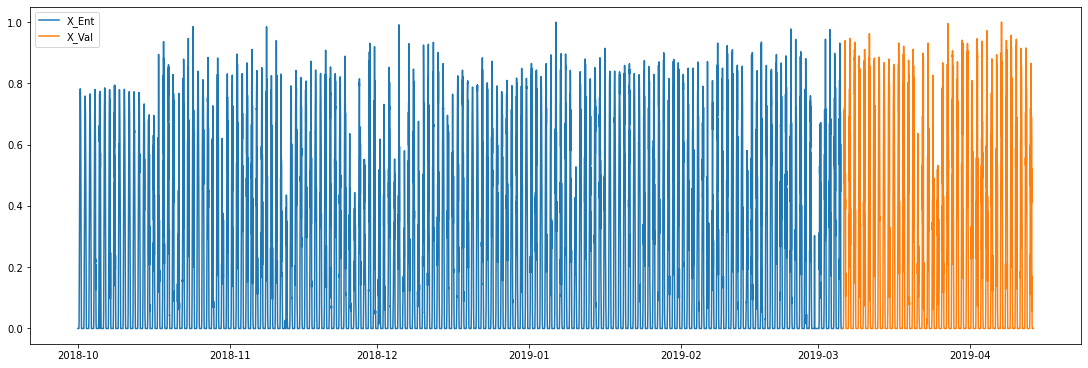

In [14]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm, label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm, label="X_Val")

ax.legend()
plt.show()

# Création des datasets

In [15]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(series, longueur_sequence, longueur_sortie, batch_size,shift):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  dataset = dataset.map(lambda x: (x[0:longueur_sequence][:,:],tf.expand_dims(x[-longueur_sortie:][:,0],1)))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [16]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 2*24*4  # 4 jours (288*15min)
longueur_sortie = 96        # 24h (96*15min)
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm,longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm,longueur_sequence,longueur_sortie,batch_size,shift)

In [17]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

114
(128, 192, 1)
(128, 96, 1)


In [18]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0].shape)
  print(element[1].shape)

27
(128, 192, 1)
(128, 96, 1)


On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [19]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # #60x((32,5,779),(32,5,1)) => x = 60x(32,5,779) ; y = 60x(32,5,1)

# Recombine les données
x = np.asarray(x,dtype=np.float32)      # 60x(32,5,779) => (60,32,5,779)
y = np.asarray(y,dtype=np.float32)      # 60x(32,5,1) => (60,32,5,1)

x_train = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],longueur_sequence,x.shape[3])))     # (60,32,5,779) => (60*32,5,779)
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))     # (60,32,5,1) => (60*32,5,1)

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

(14592, 192, 1)
(14592, 96, 1)


Puis la même chose pour les données de validation :

In [20]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))

# Recombine les données
x = np.asarray(x,dtype=np.float32)
y = np.asarray(y,dtype=np.float32)

x_val = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],longueur_sequence,x.shape[3])))
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

(3456, 192, 1)
(3456, 96, 1)


# Affichage des séries

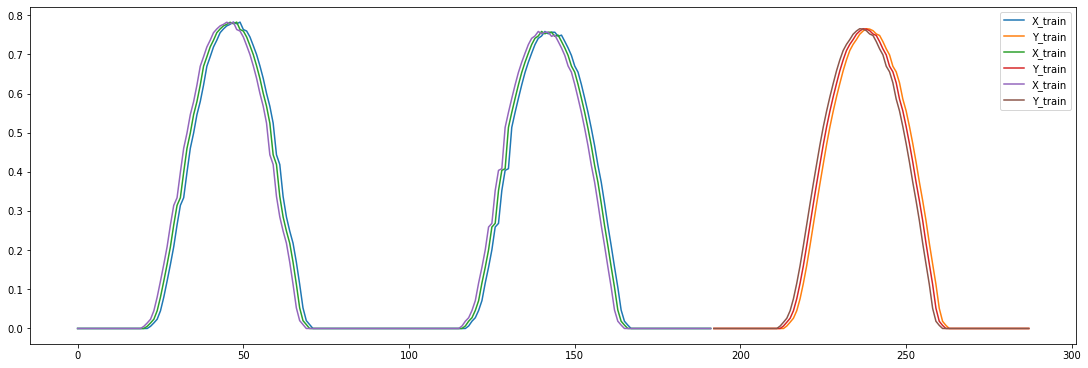

In [31]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

for i in range(0,3):
  ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence),x_train[i],label="X_train")
  ax.plot(np.linspace(longueur_sequence,longueur_sequence+longueur_sortie-1,longueur_sortie),y_train[i],label="Y_train")

ax.legend()
plt.show()

# Création du modèle Seq2Seq basique (avec encodeur simple GRU)

Notre modèle Séquence vers Séquence est composé :
- D'un encodeur, qui comprend une couche GRU uni-directionnelle
- D'un décodeur, qui comprend une couche GRU uni-directionnelle. De plus, deux couches denses sont utilisées pour recréer la sortie univariée à partir des sorties des cellules GRU.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Seq2Seq_basique_2.png?raw=true' />

**1. Création de la couche d'encodeur**

In [21]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,name="GRU_Encodeur")
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée encodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_enc : Sortie encodeur       : (batch_size,1,128)
  #     out_hid : Sortie vecteur caché  : (batch_size,1,128)
  def call(self, input, hidden=None):
    out_enc, out_hid = self.couche_GRU(input,initial_state=hidden)
    return out_enc, out_hid


**2. Création de la couche de décodeur**

In [22]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    self.init_state = True
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,name="GRU_Decodeur")
    self.couche_Dense = tf.keras.layers.Dense(units=1,kernel_regularizer=tf.keras.regularizers.l2(self.regul),input_dim=self.dim_GRU)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée décodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_dec : Sortie décodeur       : (batch_size,128)
  #     out_hid : Sortie vecteur caché  : (batch_size,128)
  def call(self,input,hidden=None):
    if self.init_state == True:
      out_dec, out_hid = self.couche_GRU(input)
      self.init_state = False
    else:
      out_dec, out_hid = self.couche_GRU(input,initial_state=hidden)
    out_dec = self.couche_Dense(out_dec)
    return out_dec, out_hid

**3. Création de la couche réseau**

In [23]:
class Net_GRU(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, longueur_sortie, regul=0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.dim_GRU = dim_GRU
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:      Entrée réseau         : (batch_size,longueur_sequence,1) 
  #     output_seq  Sorties réelles       : (batch_size, longueur_sortie,1)
  # Sorties :
  def call(self,input,output_seq,training=False):
    longueur_entree = input.shape[1]
    sortie = []

    enc_out, enc_hid = self.encodeur(input[:,0:1,:])

    for i in range(1,longueur_entree):
      enc_out, enc_hid = self.encodeur(input[:,i:i+1,:],enc_hid)

    dec_input = tf.expand_dims(input[:,-1,:],1)
    dec_hid = enc_hid

    if (training == False):
      for i in range(0,self.longueur_sortie):
        dec_out, dec_hid = self.decodeur(dec_input, dec_hid)
        dec_input = tf.expand_dims(dec_out,-1)
        sortie.append(dec_out)
      sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))
    else:
      for i in range(0,self.longueur_sortie):
        dec_out, dec_hid = self.decodeur(dec_input, dec_hid)
        dec_input = tf.expand_dims(output_seq[:,i,:],1)
        sortie.append(dec_out)
      sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))

    return sortie

**4. Création du modèle**

In [24]:
class CustomModel(keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Calcul du gradient
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Optimisation des poids
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Mise à jour des métriques
        self.compiled_metrics.update_state(y, y_pred)

        # Retourne un dictionnaire avec les résultats
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data

        # Calcul des predictions
        y_pred = self(x, training=False)

        # Mise à jour des erreurs
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Mise à jour des métriques
        self.compiled_metrics.update_state(y, y_pred)

        # Retourne un dictionnaire avec les résultats
        return {m.name: m.result() for m in self.metrics}

In [25]:
dim_GRU = 128
drop=0.3
l2reg=0.05

entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,1))
sorties_sequences = tf.keras.layers.Input(shape=(longueur_sortie,1))


encodeur = Encodeur(dim_GRU=dim_GRU,drop=drop,regul=l2reg)
decodeur = Decodeur(dim_GRU=dim_GRU,drop=drop,regul=l2reg)

sortie = Net_GRU(encodeur,decodeur,longueur_sequence=longueur_sequence, longueur_sortie=longueur_sortie)(entrees_sequences,sorties_sequences)

model = CustomModel([entrees_sequences,sorties_sequences],sortie)
model.summary()

Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
net_gru (Net_GRU)               (None, 96, 1)        100737      input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 100,737
Trainable params: 100,737
Non-trainable params: 0
__________________________________________________________________________________________________


# Création du modèle Seq2Seq basique avec encodeur LSTM-Bidirectionnel

Notre modèle Séquence vers Séquence est composé :
- D'un encodeur, qui comprend une couche GRU uni-directionnelle
- D'un décodeur, qui comprend une couche GRU uni-directionnelle. De plus, deux couches denses sont utilisées pour recréer la sortie univariée à partir des sorties des cellules GRU.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Seq2Seq_basique_2.png?raw=true' />

**1. Création de la couche d'encodeur à base de LSTM**

La couche Bidirectionnelle appliquée à une couche LSTM retourne 5 tenseurs :
- La concaténation (ou la somme, en fonction de la méthode `merge` choisie) des états cachés avance / recul
- Le dernier état caché du LSM d'avance : (batch_size, dim_LSTM*2) si concaténation ou (batch_size,dim_LSTM) si merge
- Le derner cell-state du LSTM d'avance : (batch_size, dim_LSTM)
- Le dernier état caché du LSTM de recul : (batch_size, dim_LSTM)
- Le dernier cell-state du LSTM de recul : (batch_size, dim_LSTM)

In [ ]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,name="LSTM_Encodeur"),merge_mode="sum")
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée encodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_enc :   Sortie encodeur       : (batch_size,128)
  #     out_hid_x : Sortie vecteur caché  : (batch_size,128)
  #     state_c_x : Sortie cell state     : (btach_size,128)
  def call(self, input, hidden=None):
    out_enc, out_hid_1, state_c_1, out_hid_2, state_c_2 = self.couche_LSTM(input,initial_state=hidden)
    return out_enc, out_hid_1, state_c_1, out_hid_2, state_c_2


**2. Création de la couche de décodeur**

In [ ]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM            # Dimension des vecteurs cachés
    self.drop = drop
    self.init_state = True
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,name="LSTM_Decodeur")
    self.couche_Dense = tf.keras.layers.Dense(units=1,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée décodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_dec : Sortie décodeur       : (batch_size,1,1)
  #     out_hid : Sortie vecteur caché  : (batch_size,1,128)
  def call(self,input,hidden=None):
    if self.init_state == True:
      out_dec, out_hid, state_c = self.couche_LSTM(input)
      self.init_state = False
    else:
      out_dec, out_hid, state_c = self.couche_LSTM(input,initial_state=hidden)
    out_dec = self.couche_Dense(out_dec)
    return out_dec, out_hid

**3. Création de la couche réseau**

In [ ]:
class Net_LSTM(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, longueur_sortie, regul=0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:      Entrée réseau         : (batch_size,longueur_sequence,1) 
  #     output_seq  Sorties réelles       : (batch_size, longueur_sortie,1)
  # Sorties :
  def call(self,input,output_seq,training=False):
    longueur_entree = input.shape[1]
    sortie = []

    enc_out, enc_hid_1, enc_state_1, enc_hid_2, enc_state_2 = self.encodeur(input[:,0:1,:])

    for i in range(1,longueur_entree):
      enc_out, enc_hid_1, enc_state_1, enc_hid_2, enc_state_2 = self.encodeur(input[:,i:i+1,:],[enc_hid_1, enc_state_1, enc_hid_2, enc_state_2])

    dec_input = tf.expand_dims(input[:,-1,:],1)
    dec_hid = tf.keras.layers.Add()((enc_hid_1,enc_hid_2))
    dec_state = tf.keras.layers.Add()((enc_state_1,enc_state_2))

    if (training == False):
      for i in range(0,self.longueur_sortie):
        dec_out, dec_hid = self.decodeur(dec_input, [dec_hid,dec_state])
        dec_input = tf.expand_dims(dec_out,-1)
        sortie.append(dec_out)
      sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))
    else:
      for i in range(0,self.longueur_sortie):
        dec_out, dec_hid = self.decodeur(dec_input, [dec_hid,dec_state])
        dec_input = tf.expand_dims(output_seq[:,i,:],1)
        sortie.append(dec_out)
      sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))

    return sortie

**4. Création du modèle**

In [ ]:
class CustomModel(keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Calcul du gradient
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Optimisation des poids
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Mise à jour des métriques
        self.compiled_metrics.update_state(y, y_pred)

        # Retourne un dictionnaire avec les résultats
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data

        # Calcul des predictions
        y_pred = self(x, training=False)

        # Mise à jour des erreurs
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Mise à jour des métriques
        self.compiled_metrics.update_state(y, y_pred)

        # Retourne un dictionnaire avec les résultats
        return {m.name: m.result() for m in self.metrics}

In [ ]:
dim_LSTM = 128
drop=0.3
l2reg=0.01

entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,1))
sorties_sequences = tf.keras.layers.Input(shape=(longueur_sortie,1))


encodeur = Encodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)
decodeur = Decodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)

sortie = Net_LSTM(encodeur,decodeur,longueur_sequence=longueur_sequence, longueur_sortie=longueur_sortie)(entrees_sequences,sorties_sequences)

model = CustomModel([entrees_sequences,sorties_sequences],sortie)
model.summary()

# Entrainement du modèle

In [26]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse"])

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='mse', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
#historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])
historique = model.fit(x=[x_train,y_train],y=y_train, epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint], batch_size=batch_size)

Epoch 1/100
 45/114 [==========>...................] - ETA: 44s - loss: 0.4082 - mse: 0.1123

KeyboardInterrupt: ignored

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[20], taux[99], 0, 0.1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
from google.colab import files

max_periodes = 200

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=15,
    decay_rate=0.001)

optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Entraine le modèle
historique = model.fit(x=[x_train,y_train],y=y_train,validation_data=([x_val,y_val],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)],batch_size=batch_size)


files.download('poids_train.hdf5')

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
model.evaluate(x=[x_train,y_train],y=y_train)
model.evaluate(x=[x_val,y_val],y=y_val)

# Prédictions multi-step

In [ ]:
pred_ent = model.predict([x_train,y_train],verbose=1)
pred_val = model.predict([x_val,y_val],verbose=1)

In [ ]:
import plotly.graph_objects as go

decalage = longueur_sortie

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,0],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []
pred_index = []
step_time = []
step_val = []

max = len(pred_ent)
max = 5
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
  pred_index.append(df_etude.index[longueur_sequence+i*longueur_sortie:longueur_sequence+(i+1)*longueur_sortie])
  step_val.append(pred_ent[i,0,0])
  step_time.append(df_etude.index[longueur_sequence+i*longueur_sortie])

pred = tf.convert_to_tensor(pred)
pred = tf.reshape(pred,shape=(pred.shape[0]*pred.shape[1]))
pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pd.to_datetime(pred_index),y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))


#Affiche les prédictions sur les validations
pred = []
pred_index = []
step_time = []
step_val = []
max = len(pred_val)
max = 5
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))
  pred_index.append(df_etude.index[temps_separation+i*decalage+longueur_sequence:temps_separation+i*decalage+longueur_sequence+longueur_sortie])
  step_val.append(pred_val[i,0,0])
  step_time.append(df_etude.index[temps_separation+i*decalage+longueur_sequence])

pred = tf.convert_to_tensor(pred)
pred = tf.reshape(pred,shape=(pred.shape[0]*pred.shape[1]))
pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pd.to_datetime(pred_index),y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))



fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Prédictions single-step

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,0],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred)
pred = tf.reshape(pred,shape=(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred)
pred = tf.reshape(pred,shape=(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()